# Predicting Uncertainty:
<font color='grey' size = 5>

**Prediction Intervals from Gradient Boosting Quantile Regression**


![image](https://i.imgur.com/3Tilb52.jpg)


> What is the difference between actuaries and fortune tellers?
>
> Answer: Fortune tellers give you point estimates, but actuaries give you *prediction intervals*.  Both try to predict the future.

Models continue to become more accurate, but for certain applications, the uncertainty of an estimate is as important as the prediction itself. By using prediction intervals, which create a range of values instead of a single number, this uncertainty can be measured using quantile regression.  In insurance and finance where model risk translates to financial gain or loss, predictive analytics practitioners can reduce losses and increase profits by hedging against this risk.  

Using gradient boosting, a widely-used machine learning method, two use cases are demonstrated on open-source and reproducible data:

1. Add value to actuarial predictive models by creating prediction intervals;
2. Audit data quality in a fully-scalable manner using outlier detection.

## Introduction
---

Predictive analytics is the science of using statistics to predict the future.  This processes often involves identifying a business problem, collecting relevant data, and then making predictions that help to improve or solve the problem.  As advances in the field of machine learning produce better algorithms, the relative size of errors continues to decrease.  But even the best models are random to some degree.  

In real-world applications, a prediction about a future event will never completely match reality.  Even with the most robust validation, we can never know for certain how well a given model will perform on unseen data.  Data collected outside of the laboratory is often sparse for certain segments of the population.  In health care, models are built based on thousands of diagnosis codes, and each patient may only have a few dozen codes in common with other patients.  Credit unions and banks create models from purchase histories which contain varying line item keywords.  Websites use clickstream data which contains millions of user inputs.  In all of these examples, the data quality can vary dramatically from case-to-case.  Intuitively, those predictions which are based on low-quality data will be less reliable than those with more data.

For financial applications where the prediction is a dollar amount, model risk translates into financial risk.  In [Modern Portfolio Theory (MPT)](https://www.investopedia.com/terms/m/modernportfoliotheory.asp), investment risk is measured by the standard deviation.  This is the tendency of the asset to have a return that is above or below the average return.  Portfolio managers need to know the risk level as well as the average return in order to maintain profitability.

In insurance, actuaries are the original scientists of risk.  Traditionally, actuaries use parametric models which allow for not only the average to be estimated, but also other [risk measures](https://www.casact.org/library/studynotes/hardy4.pdf).  The Value at Risk (VaR) is a terminological name for the pth quantile of the loss distribution.  Usually this is just the 90th or 99th percentile.  Two entities with the same average but different VaR are valued very differently.

The Actuarial Standards of Practice (ASOPs) describe the procedures an actuary should follow when performing actuarial services.  ASOP No. 23 speaks to this issue of data quality and how the uncertainty behind results should be acknowledged.

>Appropriate data that are accurate and complete may not be available. The actuary should use available data that, in the actuary’s professional judgment, allow the actuary to perform the desired analysis. *However, if significant data limitations are known to the actuary, the actuary should disclose those limitations and their implications in accordance with section 4.1(b).* 
> - [ASOP No. 23 § 3.1 (emphasis added)](http://www.actuarialstandardsboard.org/asops/data-quality/).

Much research has been done to create machine learning models which create more accurate averages, but less research focuses on measuring the uncertainty of those predictions.  One of the most widely-applicable algorithms, the gradient boosting machine (GBM), has a method of estimating prediction error using quantile regression.  This allows for predictions of not only the average, but also the range or uncertainty of the prediction.  This helps to solve the problem of model risk: if an observation is predicted based on sparse data, then the prediction interval for this record will be wide; if the prediction is based on strong evidence, or in actuarial terminology has "higher credibility", then the prediction interval will be narrower.

### Quantile Regression

Most models estimate averages, but quantile regression can estimate the median, 75th percentile, 90th percentile, or any other quantile.  Quantile regression has been around since the 1800s for linear models but is not very well known within the machine learning community.  The reasons for this are twofold: there has only been [limited research](https://journals.sagepub.com/doi/abs/10.1177/1471082X18759142?journalCode=smja) on practical applications outside of academia, and all machine learning competitions, such as the popular website [kaggle.com](https://www.kaggle.com/competitions), have focused on model accuracy.  

In [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning), the goal is to model the target conditioned on data.  The process of creating a model from data is called *training*.  During training, many models are built and compared, but only the best is kept.  One of the choices that a modeler makes when fitting a model is what defines a "best" model.  This is controlled by the loss function.  When the value of the loss function is high, then the model is considered "worse".  When the loss is low, the model is considered "better".  

**Theorem 1: Using Mean Squared Error as a loss function results in predicting the mean.**

This is the default setting in most machine learning software.  The proof can be shown rather easily.  This mathematical convenience is another reason why MSE is so popular.  Before modern computers, models were limited to loss functions which computers could optimize.

**Theorem 2: Any quantile, such as the median, can be predicted by modifying the loss function.**

The math behind this is more challenging, but the payoff is greater because predicting quantiles tells more about the distribution than merely the average.  

***Theorem 1 Proof:***

Let $Y$ by the target value, $\hat{Y}$ the predicted value, and $n$ the number of observations.  The Mean Squared Error (MSE) is the mean of the squares of the residuals.  To optimize the model, find the minimum value of the loss function with respect to u.

$$\text{Loss} = \text{MSE} = \frac{1}{n}\sum_{1}^{n} (Y_i - u)^2$$

Take the derivative and set the result equal to zero.

$$\frac{d}{du} \frac{1}{n}\sum_{1}^{n} (Y_i - u)^2 = \frac{-2}{n}\sum_{1}^{n} (Y_i - u) = 0$$

Because the right hand side is 0, we can remove $\frac{-2}{n}$.  Solve for $u$ to find that the minimum value is at the average.

$$\sum_{1}^{n} (Y_i - u) = 0 \Rightarrow u = \frac{1}{n}\sum_{1}^{n} Y_i  \space \blacksquare$$

***Theorem 2 Proof:***

To make inferences about the distribution of $Y$, we first need to define the distribution function $F_Y(y) = Pr(Y \leq y)$.  For $\tau \in(0,1)$, the $\tau$th quantile of Y the number $y_{\tau}$ such that $F(y_{\tau}) = \tau $.

Define the *loss function* as $\rho_{\tau}(y)=y(\tau-\mathbb{I}_{(y<0)})$, where $\mathbb{I}$ is an indicator function. A specific quantile can be found by minimizing the expected loss of $Y-u$ with respect to $u$.
$$\text{Loss} = E(\rho_{\tau}(Y-u)) = (\tau-1)\int_{-\infty}^{u}(y-u)dF_{Y}(y)+\tau\int_{u}^{\infty}(y-u)dF_{Y}(y) $$

Just as before, we take the derivative with respect to $u$ and set it equal to zero.

$$0=(1-\tau)\int_{-\infty}^{u}dF_{Y}(y)-\tau\int_{u}^{\infty}dF_{Y}(y)$$

This equation reduces to
$0=F_{Y}(u)-\tau$
and then to
$F_{Y}(u)=\tau$.  

Hence, $u$ is $\tau$th quantile of the random variable Y. Because the median is just the 50th percentile, setting $\tau = 0.5$ results in estimating the median.  This implies that any quantile can be predicted by setting the corresponding $\tau$ in the loss function.  $\space \blacksquare$

**Intuition:**

A residual is the error between the prediction and target value, $y_i - \hat{y_i}$.  For RMSE and MAE, positive and negative residuals are penalized equally.  This is because both loss functions are *even*. An even function returns the same output for a negative or positive input.  

$$\text{MSE}(Y - \hat{Y}) = \text{MSE}(\hat{Y} - Y) = \frac{1}{n}\sum_{1}^{n} (Y_i - Y_i)^2$$

$$\text{MAE}(Y - \hat{Y}) = \text{MAE}(\hat{Y} - Y) = \frac{1}{n}\sum_{1}^{n} |Y_i - Y_i|$$

Intuitively, this means that there the average (or median) residual should be zero.  For quantile loss, positive residuals are penalized differently than negative residuals, which causes the model to aim *above* the center (for quantiles above 0.50) and *below* the center (for quantiles below 0.50).

Say that $Y$ is uniform on the integers 1,..., 10.  Then the $dF_Y(y)$ just turns into $\frac{1}{10}$ since all $Y_i$'s have the same probability, and the integrals turn into summation.

Then the quantile loss is

$$\frac{1}{10}(\tau - 1)\sum_{y_i<u}(y_i - u) + \frac{1}{10} \tau \sum_{y_i>u}(y_i - u)$$

Ignoring the $\frac{1}{10}$, this is just

$$(\tau - 1) \sum\text{(Positive Residuals)} + \tau \sum\text{(Negative Residuals)}$$

When $\tau = 0.5$ the positive and negative residuals are weighted equalled.  This is just MAE.

Say that $\tau = 0.10$ and that the model's "guess" for the 10th percentile too low.  Then most of the residuals will be positive because the guess is too low.  The negative residuals will be very small because they get hit by $0.10$.

$$(0.1 - 1) \sum\text{(Positive Residuals)} + 0$$

This will result in a small value, or a low loss penalty.  This tells the model that a low guess is in the right direction.

Conversely, say that the model's "guess" for the 10th percentile is too high.  Then the residuals will often be negative and so the weight will be on the second term and so the loss will be *high*.  This tells the model that a high guess is in the wrong direction.

### Gradient Boosting

Gradient Boosting is a technique which forms an ensemble of weak learners to create a single prediction.  These weak learners are often decision trees, which means that they can apply to either regression or classification problems.  Each tree is built to correct the error of the previous tree.  This stage-wise approach allows for hundreds or thousands of decision trees to be ensembled together.  A detailed description of the GBM algorithm can be found in chapter 8.2 of [(An Introduction to Statistical Learning)](http://faculty.marshall.usc.edu/gareth-james/ISL/)

GBMs are an exceptionally versatile method, but they do not apply to all predictive modeling applications.  Consideration should be taken to the advantages and disadvantages of the modeling method to determine if it will provide the best solution to the predictive analytics problem.

**Advantages:**
- High prediction accuracy;
- Has been empirically shown to succeed on a wide class of problems;
- Performs variable selection;
- Handles non-linearities, interaction effects, is resilient to outliers, and corrects for missing values;
- Deals with class imbalance directly by weighting observations.

**Disadvantages:**
- Requires a large sample size;
- Can takes longer to train than other methods;
- Does not detect linear combinations of features;
- Can overfit if not tuned correctly.


## Application 1: Adding Prediction Intervals to Risk Scores

-----------
A common use for predictive models is in creating risk scores.  A risk score is a value from 1-10, or some other high number, which is intended to measure the tendency of the person to by expensive or not.  In health insurance, this is the cost of the person relative to the average.  A risk score of 1.5 means that on average, the person costs 50% more than the average person in their population.  

In the table below, three members are represented for the sake of example.  Member B at times appears to have the lowest cost, at times when their score is 1.1, but expensive at others, when their score is 10.1.  Members A and C have relatively lower variance in their scores.  For an insurance practitioner only looking at a single number, at a single point in time, based on a single data sample, all three risk scores appear to have the same precision, but in truth this is not the case.

![Risk Scores](https://media.giphy.com/media/ME38o1vgzyCIqFY0J5/giphy.gif "Risk Score Example")

The risk score is a random variable.  If the data was reshuffled and the model refit, then the risk score will change.  A common means of interpreting the average is in terms of frequency.  For example, if there were 100 members with the same characteristics as A, if their total health care cost were added together and divided by 100 then this would be about 1.5 times the overall average of A, B, C, and all other members.

Using quantile regression, we can use GBMs to create a range of values.


### Data

The focus of this paper was on the methodology and reproducibility rather than the result itself.  The data consists of 1,338 records of patient health care costs.  This data is [publically available](https://www.kaggle.com/mirichoi0218/insurance) for download and was also cleaned and republished as a companion to the textbook *Machine Learning with R* by Brett Lantz.  There are six columns which are relate the patient's demographics to their annual health care cost.  

**age**: age of primary beneficiary

**sex:** insurance contractor gender, female, male

**bmi:** Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

**children:** Number of children covered by health insurance / Number of dependents

**smoker:** Smoking

**region:** the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

**charges:** Annual health insurance claims



In [124]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import preprocessing, model_selection, ensemble, linear_model
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

data = pd.read_csv("insurance.csv")

In [125]:
def style_table(table):
    return(table.style.set_table_styles(
    [{'selector': 'tr:nth-of-type(odd)',
      'props': [('background', '#eee')]}, 
     {'selector': 'tr:nth-of-type(even)',
      'props': [('background', 'white')]},
     {'selector': 'th',
      'props': [('background', '#606060'), 
                ('color', 'white'),
                ('font-family', 'verdana')]},
     {'selector': 'td',
      'props': [('font-family', 'verdana')]},
     {'selector': 'th',
     'props':[('max-width', '100px')]}
    ]
    ).hide_index())

The top five records are shown below.

In [126]:
style_table(data.head(5))

age,sex,bmi,children,smoker,region,charges
19,female,27.9,0,yes,southwest,16884.9
18,male,33.77,1,no,southeast,1725.55
28,male,33,3,no,southeast,4449.46
33,male,22.705,0,no,northwest,21984.5
32,male,28.88,0,no,northwest,3866.86


The the age, sex, bmi, children, smoker, and region columns are used as the predictors.  The response variable is the annual claims.  One-third of the records are held out as a test set.  A random seed is set to ensure reproducibility of results.

In [127]:
x = data.drop(["charges"], axis = 1)
y = data["charges"]

#convert categories to 0-1 columns
le = preprocessing.LabelEncoder()
x = x.apply(le.fit_transform)

#train/test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.33, random_state = 42)

Categorical columns are converted to binary columns.  Two-thirds of the records are used for training and the remaining one-third used as a holdout set. 

Text(0.02, -0.02, 'The distribution of annual medical claims is right-skewed and has a mean of $13,270.')

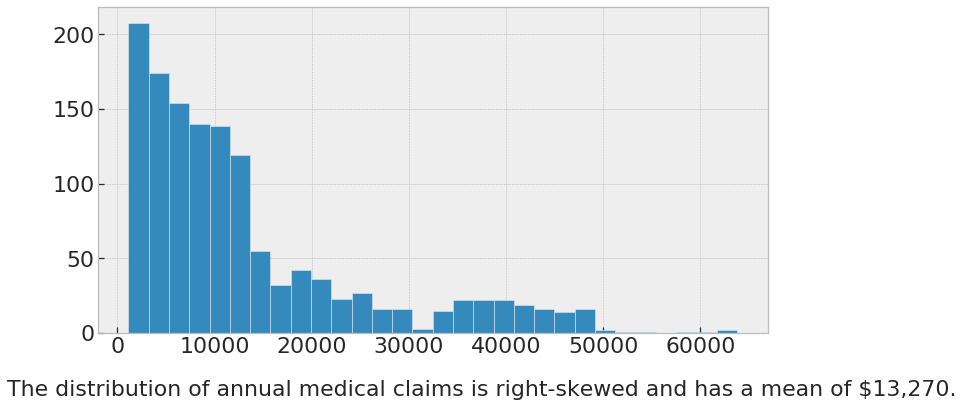

In [128]:
font = {'family' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
mpl.style.use("bmh")
plt.hist(data['charges'], bins = 30)
plt.gcf().set_size_inches(12, 6)
plt.figtext(.02, -0.02, "The distribution of annual medical claims is right-skewed and has a mean of $13,270.")

### Predicting the Average

The first step in modeling is to predict the average for each patient.  The loss function will be MSE so that the prediction will be the mean, as shown in Theorem 1. 

In addition, a linear model is fit to serve as a baseline against the GBM.


In [129]:
linear_model = sk.linear_model.LinearRegression()
linear_model.fit(x_train, y_train);

A random grid search of parameters is used with ten-fold cross validation.  This means that each model trained, the parameters are calibrated based on 90% of the data and evaluated on the remaining 10% (or 1/10th).  Once the best parameters have been selected, the model performance is evaluated on the unseen holdout data.  Because this is a relatively small data set for a GBM, these measures will help to prevent the model from over-fitting.  

In order to make this example faster to reproduce, only the final parameters are shown.  A range of values was tested such as `'n_estimators: [500, 1000, 2000]', 'max_depth':[2,3,4,5]`, and so forth.  There are several different methods for tuning parameters in addition to a grid search such as a random search or Bayesian optimization which are beyond the scope of this paper.

In [130]:
#predict the mean
parameters = {
    'n_estimators': [1000], 
    'max_depth': [4],
    'min_samples_split': [5],
    'learning_rate': [0.1], 
    'loss': ['ls']
}
mean = ensemble.GradientBoostingRegressor(**parameters, random_state = 42)
mean_cv = model_selection.GridSearchCV(mean, parameters, cv=10)
mean_cv.fit(x_train, y_train);

The best set of parameters is recorded.  

In [131]:
mean_cv.best_params_

{'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 4,
 'min_samples_split': 5,
 'n_estimators': 1000}

### Predicting Quantiles

Recall that any quantile can be estimated.  For this example, a symmetric range between the 95th and 5th percentiles is chosen. These bounds will form the prediction interval.  Depending on the nature of the problem and the needed level of confidence, these can be made wider or narrower.

In [132]:
#predict the upper percentile
parameters = {
    'loss': 'quantile',
    'alpha': 0.95,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'min_samples_split': 5,
    'max_depth': 4
}

upper = ensemble.GradientBoostingRegressor(**parameters, random_state = 42)
upper.fit(x_train, y_train)

#predict the lower percentile
parameters = {
    'loss': 'quantile',
    'alpha': 0.05,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'min_samples_split': 5,
    'max_depth': 4
}

lower = sk.ensemble.GradientBoostingRegressor(**parameters, random_state = 42)
lower.fit(x_train, y_train);

While the parameter values for the `learning_rate`, `n_estimators`, `min_samples`, and `max_depth` are not retuned, technically they should be.  As the loss function changes, the minimum value in the parameter space moves.  The further away $\tau$ is from 0.5 the more significant this becomes.

In [133]:
def score_model(model):
    scores = model_selection.cross_validate(model, x_test, y_test, cv = 3, scoring = ('r2', 'neg_mean_absolute_error'))
    r2 = scores['test_r2'].mean().round(3)
    mae = scores['test_neg_mean_absolute_error'].mean().round(2)
    return({"r2": r2, "mae": -mae})
    
score_model(linear_model)

{'r2': 0.75, 'mae': 4242.87}

The linear model has an R-Squared of 0.75 and an MAE of 4242.9.  

In [134]:
score_model(mean_cv.best_estimator_)

{'r2': 0.809, 'mae': 3160.52}

As expected, the GBM significantly improves on those metrics.  The R-Squared is higher and the MAE is lower.

In [135]:
df = x_test\
        .assign(charges = y_test,
                linear_pred = linear_model.predict(x_test),
                pred_lower = lower.predict(x_test),
                pred_mean = mean_cv.predict(x_test),
                pred_upper = upper.predict(x_test)
                )

p = df[['age', 'sex', 'charges', 'pred_lower', 'pred_mean', 'pred_upper']]\
    .rename(columns = {
    'age': 'Age', 
    'sex': 'Gender', 
    'charges': 'Claims', 
    'pred_lower': '5th Prediction Percentile',
    'pred_mean': 'Average Prediction',
    'pred_upper': '95th Prediction Percentile'})\
    .head(3)

style_table(p)

Age,Gender,Claims,5th Prediction Percentile,Average Prediction,95th Prediction Percentile
27,0,9095.07,8689.43,10241.7,22949
18,0,5272.18,5060.69,10599.5,18030.4
46,0,29331,24531.5,29278.6,32011.3


The above table shows three members along with a central, middle, and high prediction of their claims.

<Figure size 864x864 with 0 Axes>

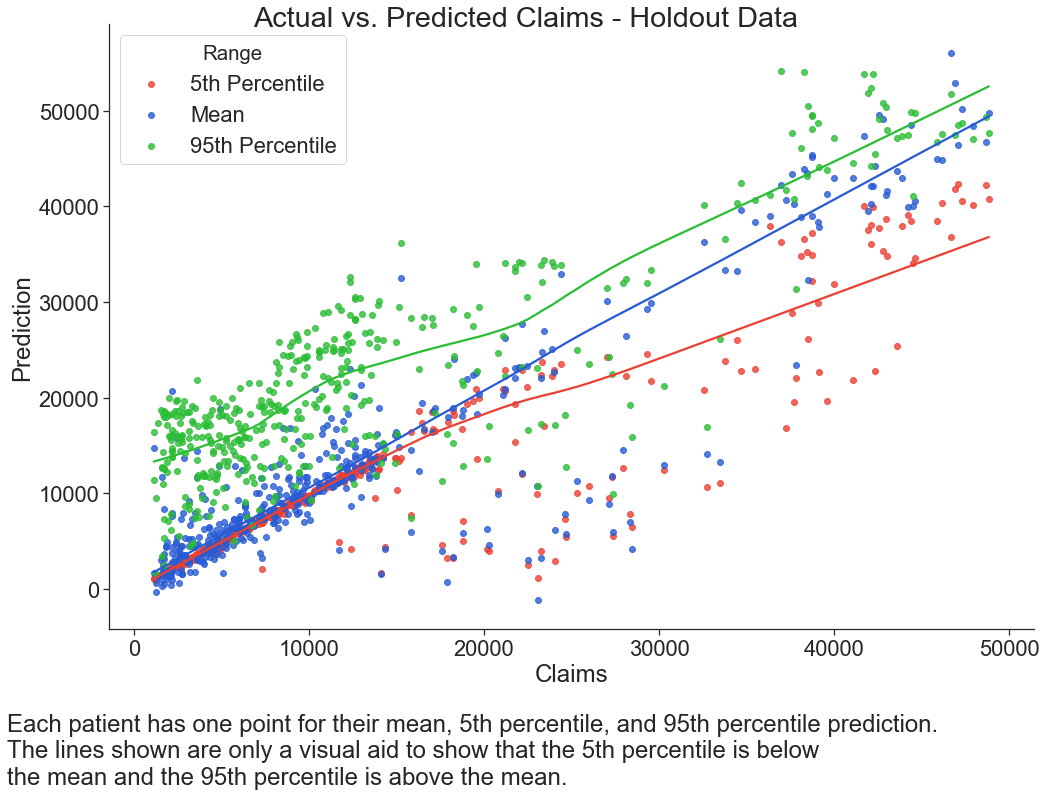

In [136]:
sns.set(font_scale = 2)
sns.set_style("ticks")

custom_colors = ["#eb4034", "#285bd4","#2bbd35"]

plt.figure(figsize=(12, 12))
df1 = df.assign(Range = '5th Percentile').rename(columns={'pred_lower': "Prediction"})
df2 = df.assign(Range = 'Mean').rename(columns={'pred_mean': "Prediction"})
df3 = df.assign(Range = '95th Percentile').rename(columns={'pred_upper': "Prediction"})
long_df = pd.concat([df1, df2, df3])\
    .rename(columns={'charges': "Claims"})
p = long_df[['Claims', 'Prediction', 'Range']].where(long_df['Claims'] < 50000)
lm = sns.lmplot(x = 'Claims', y = 'Prediction', hue = 'Range', data = p,
          height = 10, aspect = 1.5, ci = None, legend_out = False, lowess = True,
          palette = custom_colors)
fig = lm.fig
fig.suptitle("Actual vs. Predicted Claims - Holdout Data")
plt.figtext(.02, -0.1, "Each patient has one point for their mean, 5th percentile, and 95th percentile prediction.  \nThe lines shown are only a visual aid to show that the 5th percentile is below \nthe mean and the 95th percentile is above the mean.");

---

## Application 2: Data Auditing with Outlier Detection

A colloquial phrase speaking to the importance of data quality in statistics is "garbage in; garbage out."  Any result can only be as useful as the data on which it is based.  Quantile regression can be used to detect bad data.  By training the model on good, useful examples, a rule can be created to detect if a point is an outlier.  Out of the 1,300 patients in this study, this method correctly detects only a handful of cases which show irregular values.  

Some of the advantages to this method are:
* Scalability 
* No reliance on specialized domain knowledge 
* Non-parametric (few statistical assumptions are needed)
* One a model has been trained it can audit new data very quickly

The [Inter Quartile Range](https://en.wikipedia.org/wiki/Interquartile_range) is a statistical measure of central tendency. This is the difference range between the 75th and 25th percentiles. These are commonly displayed in a box plot as the "width" of the box.  The center of the box represents the median.  


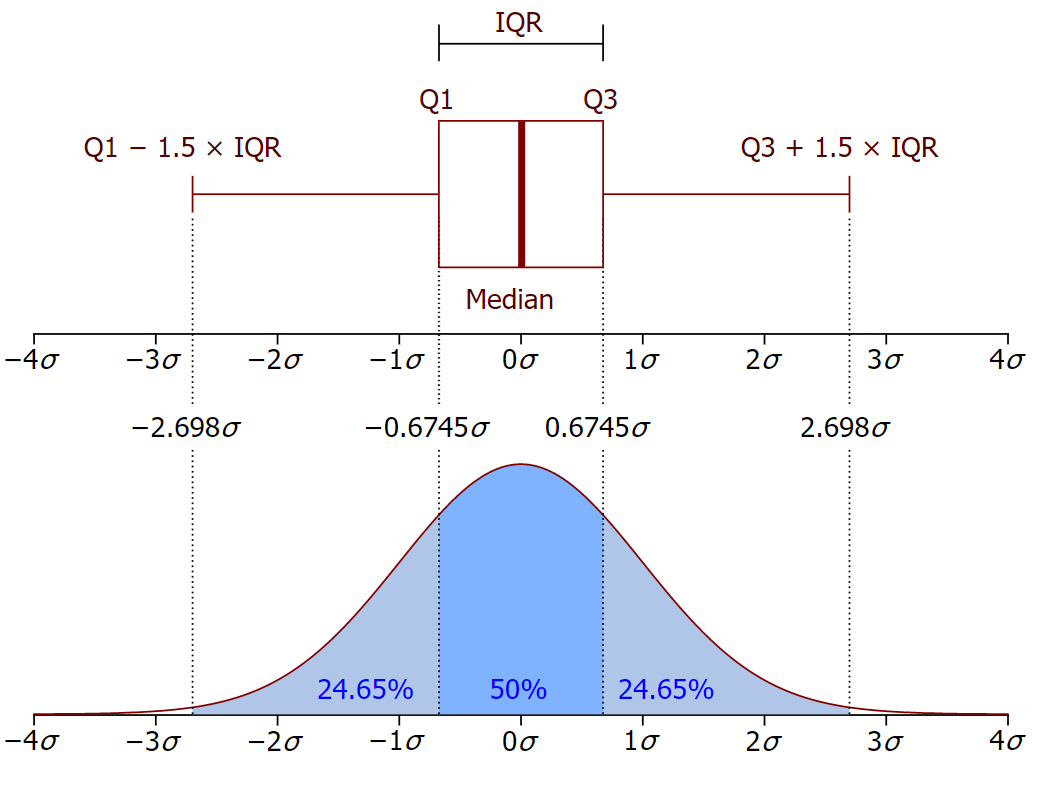

In [187]:
Image(filename= "IQR.PNG", width = 500, height = 250)

Based on the IQR, a rule can be defined to identify outlying observations.  For example, an outlier is a point which falls below $\text{Q1} - 1.5\times \text{IQR}$ or above $\text{Q3} + 1.5 \times \text{IQR}$.  The range in this example is wider, as the 95th and 5th percentiles are used, but the same idea applies.

In [138]:
df = df.assign(IQR = df.pred_upper - df.pred_lower)
df = df.assign(pred_outlier = (df.charges < df.pred_lower - 1.5*df.IQR) | (df.charges > df.pred_upper + 1.5*df.IQR))
df['pred_outlier'].value_counts()

False    432
True      10
Name: pred_outlier, dtype: int64

Out of 442 total patients in the holdout set, there are only 10 patients who have observed claim costs which are outside of the 5th and 95th prediction intervals. 

In [139]:
style_table(df.where(df['pred_outlier'] == 1).dropna().head(10)[['age', 'sex', 'bmi', 'children', 'smoker', 'region']])

age,sex,bmi,children,smoker,region
22,0,235,4,0,3
12,0,27,3,0,1
46,1,491,0,0,2
14,0,8,2,1,1
34,0,538,5,0,2
36,0,539,0,1,2
16,1,69,2,0,0
46,0,467,0,0,0
28,1,146,5,0,3
8,0,245,4,0,0


A simple check confirms that these are, intuitively, atypical patients.

1.  Patient BMI is extremely high.
2.  Patient is listed as 12 years old and having 3 children.  This is likely a coding error.
3.  Impossibly high BMI.
4.  Impossibly low BMI.
5.  Impossibly high BMI.
6.  Impossibly high BMI.
7.  etc, etc.

Depending on the data, there could be many reasons for there being values such as this.  These could be due to recording errors, database errors, outlying values due to forgery or tampering, or errors in way that the data is retrieved.  


## Discussion

**Percentiles cannot be aggregated like averages.**

While this is true for averages, some algebra will show why this is the so.  

Take a given vector $Y$ with $n$ observations.

$$\text{Mean}(Y) = \frac{1}{n}\sum_{1}^{n} Y_i$$

Imagine that there is some binary variable such as Gender, called $j \in \{A,B\}$, so that each $i$ is in exactly one group.  Then converting from group averages to the overall average is straight forward because the sum breaks apart.

$$\frac{1}{n}\sum_{1}^{n} Y_i = \frac{1}{n} (\sum_{j = A} Y_i + \sum_{j = B} Y_i)$$

This means that average predictions can be sliced across any dimension of the data.  For percentiles, however, this is not the case because there is no such algebra.  This means that a graphs or calculations which use an "average" or "sum" of the quantiles will be incorrect.

<br>

**Training time can be slow.**

In this example, the data was relatively small and so training the model took only minutes.  In larger data sets, this training time is often an issue.  If the 75th or 71st percentiles were needed, then a new model would need to be trained.  

**Outlier detection is not a substitute for data quality.**

The method of outlier detection relies on learning from good examples in order to detect outliers.  There is nothing that a model can do to improve the situation if the entire data set is of low quality.  Just as with any type of model, the accuracy improves with a larger sample size and more features.  The prediction intervals will be more accurate when the data is better.

## Further Research

The output of a GBM in a classification setting is a probability, and so in theory prediction intervals can be made to provide an upper and lower bound to this probability; however, in [scikit learn](https://scikit-learn.org/stable/) there is no support for quantile regression for classification problems today.  This may be added in the future.

While this example used Python, quantile regression can be performed in most software packages that allow for custom loss functions.  In R, for instance, this can be done by manually specifying the score function in XGboost.  An explanation of how this can be done is available from [Benoit Descamps](https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b).

Quantile regression also works for decision trees, random forest, and neural nets.  [Max Ghenis](https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3) published a tutorial in 2018 which describes several of these implementations.
